# Rumor And Stance Detection
This project is a Multi-task Learning of rumor and stance detection. Using Pytorch library for the multi-task RNN model and FastText for word embedding.

### Basic imports and defines

In [1]:
import torch
import torch.nn as nn
from IPython.display import Image
%matplotlib inline

# GRU params
input_length = 400              # the size of each embedded tweet (the size of the input vector)
hidden_length_rumors = 400      # the size of the hidden vectors of the rumor detection task GRU
hidden_length_stances = 400     # the size of the hidden vectors of the stance detection task GRU
hidden_length_shared = 200      # the size of the hidden vectors of the shared GRU
output_dim_rumors = 3           # output size for rumor detection (True rumor, False rumor, Unverified)
output_dim_stances = 4          # output size for stance classification (Support, Deny, Query, Comment)

task_stances_no = 1
task_rumors_no = 2

## Building our model
Our model consists of 3 GRU layers:
- Task specific layer for Stance detection task
- Shared layer for both tasks
- Task specific layer for Rumor detection task

The inputs are vectors representing tweets after embedding with [*fastText*](https://fasttext.cc/) library.

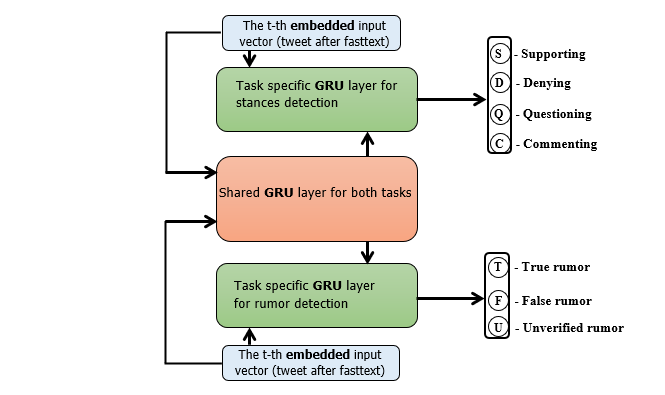

In [2]:
Image(filename='model\\Multi-task model.PNG', embed=True) 

### Our implementation of GRUCell for the task specific layers

In [3]:
class GRUCellTaskSpecific(torch.nn.Module):
    """
    This class is our implementation of GRUCELL for the task specific layers,
    which includes the sharedGRU result in it`s computations.
    """
    def __init__(self, input_length=250, hidden_length=100, hidden_length_shared=100):
        super(GRUCellTaskSpecific, self).__init__()
        self.input_length = input_length
        self.hidden_length = hidden_length
        self.hidden_length_shared = hidden_length_shared

        # update gate components
        self.linear_w_z = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_u_z = nn.Linear(self.hidden_length, self.hidden_length, bias=True)
        self.linear_us_z = nn.Linear(self.hidden_length_shared, self.hidden_length, bias=True)
        self.activation_z = nn.Sigmoid()

        # reset gate components
        self.linear_w_r = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_u_r = nn.Linear(self.hidden_length, self.hidden_length, bias=True)
        self.linear_us_r = nn.Linear(self.hidden_length_shared, self.hidden_length, bias=True)
        self.activation_r = nn.Sigmoid()

        # new memory components
        self.linear_w_hn = nn.Linear(self.input_length, self.hidden_length, bias=True)
        self.linear_u_hn = nn.Linear(self.hidden_length, self.hidden_length, bias=True)
        self.linear_us_hn = nn.Linear(self.hidden_length_shared, self.hidden_length, bias=True)
        self.activation_hn = nn.Tanh()

    def update_gate(self, x, h_prev, h_shared_new):
        x_new = self.linear_w_z(x)
        h_new = self.linear_u_z(h_prev)
        hs_new = self.linear_us_z(h_shared_new)
        z = self.activation_z(x_new + h_new + hs_new)
        return z

    def reset_gate(self, x, h_prev, h_shared_new):
        x_new = self.linear_w_r(x)
        h_new = self.linear_u_r(h_prev)
        hs_new = self.linear_us_r(h_shared_new)
        r = self.activation_r(x_new + h_new + hs_new)
        return r

    def new_memory(self, x, h_prev, h_shared_new, r):
        x_new = self.linear_w_hn(x)
        h_new = r * self.linear_u_hn(h_prev)
        hs_new = self.linear_us_hn(h_shared_new)
        nm = self.activation_hn(x_new + h_new + hs_new)
        return nm

    def forward(self, x, h_prev, h_shared_new):
        # Equation 1: the update gate
        z = self.update_gate(x, h_prev, h_shared_new)

        # Equation 2. reset gate vector
        r = self.reset_gate(x, h_prev, h_shared_new)

        # Equation 3: The new memory component
        nm = self.new_memory(x, h_prev, h_shared_new, r)

        # Equation 4: the new hidden state
        h_new = (1 - z) * nm + z * h_prev

        return h_new

- For the shared layer we will use the existing implementation of [*torch.nn.GRUCell*](https://pytorch.org/docs/stable/generated/torch.nn.GRUCell.html#torch.nn.GRUCell).


### The Multi-task model implementation

In [4]:
class GRUMultiTask(torch.nn.Module):
    """
    Our implementation of the Multi-task GRU model, containing 3 GRU layers: 1 shared layer for both tasks
    and task specific layer for each task.
    """
    def __init__(self, input_length=250, hidden_length_rumors=100, hidden_length_stances=100, hidden_length_shared=100,
                 loss_func='CrossEntropyLoss', is_dropout=False, drop_prob=0):
        super(GRUMultiTask, self).__init__()
        self.input_length = input_length
        self.hidden_length_rumors = hidden_length_rumors
        self.hidden_length_stances = hidden_length_stances
        self.hidden_length_shared = hidden_length_shared
        self.is_dropout = is_dropout

        if loss_func != 'CrossEntropyLoss' and loss_func != 'BCELoss' and loss_func != 'L1Loss' \
                and loss_func != 'MSELoss':
            self.loss_func = 'CrossEntropyLoss'
        else:
            self.loss_func = loss_func

        self.gru_cell_rumors = GRUCellTaskSpecific(self.input_length, self.hidden_length_rumors, 
                                                   self.hidden_length_shared)
        self.gru_cell_stances = GRUCellTaskSpecific(self.input_length, self.hidden_length_stances, 
                                                    self.hidden_length_shared)
        self.gru_cell_shared = nn.GRUCell(self.input_length, self.hidden_length_shared, bias=True)

        # for final classification
        self.linear_v_rumors = nn.Linear(self.hidden_length_rumors, output_dim_rumors, bias=True)
        self.linear_v_stances = nn.Linear(self.hidden_length_stances, output_dim_stances, bias=True)

        if self.is_dropout:
            self.dropout = nn.Dropout(drop_prob)

        # if we use CrossEntropyLoss we don't need to apply softmax because
        # it (CrossEntropyLoss) apply a log_softmax layer after our final layer
        if self.loss_func != 'CrossEntropyLoss':
            self.activation_y_softmax_rumors = nn.Softmax(dim=0)
            self.activation_y_softmax_stances = nn.Softmax(dim=0)

    def forward(self, batch, h_prev_shared, m, h_prev_rumors=None, h_prev_stances=None):
        outputs = []
        for raw in batch:
            r = raw.view(1, self.input_length)
            h_s = h_prev_shared.view(1, self.hidden_length_shared)
            h_prev_shared = self.gru_cell_shared(r, h_s)
            h_prev_shared = h_prev_shared.view(self.hidden_length_shared)

            if m == task_rumors_no:
                h_prev_rumors = self.gru_cell_rumors(raw, h_prev_rumors, h_prev_shared)
                if self.is_dropout:
                    h_prev_rumors = self.dropout(h_prev_rumors)
                v = self.linear_v_rumors(h_prev_rumors)
                if self.loss_func != 'CrossEntropyLoss':
                    output = self.activation_y_softmax_rumors(v)
                else:
                    output = v
            else:  # m == task_stances_no
                h_prev_stances = self.gru_cell_stances(raw, h_prev_stances, h_prev_shared)
                if self.is_dropout:
                    h_prev_stances = self.dropout(h_prev_stances)
                v = self.linear_v_stances(h_prev_stances)
                if self.loss_func != 'CrossEntropyLoss':
                    output = self.activation_y_softmax_stances(v)
                else:
                    output = v

            outputs.append(output)
        if m == task_rumors_no:
            return torch.stack(outputs), h_prev_shared, h_prev_rumors
        else:  # m == task_stances_no
            return torch.stack(outputs), h_prev_shared, h_prev_stances

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.hidden_length_rumors).zero_(),   # for rumors
                  weight.new(self.hidden_length_stances).zero_(),  # for stances
                  weight.new(self.hidden_length_shared).zero_())   # for shared
        return hidden

## Dataset  
Our dataset is a combination of the below datasets:
-  [*RumourEval 2019 data*](https://figshare.com/articles/RumourEval_2019_data/8845580)
-  [*Twitter 15-16*](https://www.dropbox.com/s/7ewzdrbelpmrnxu/rumdetect2017.zip?file_subpath=%2Frumor_detection_acl2017)

After preprocessing:  

For rumor detection task:  

|             |   True rumor   |   False rumor   |   Unverified   |   Total   |
|:------------|:--------------:|:---------------:|:--------------:|:---------:|
| **Training**| 627 | 531 | 551 | 1709 |
| **Validation**| 58 | 68 | 74 | 200 |
| **Test**| 61 | 79 | 60 | 200 |

For stance detection task:  

|             |   Support   |   Deny   |   Query   |   Comment   |   Total   |
|:------------|:--------------:|:---------------:|:--------------:|:--------------:|:---------:|
| **Training**| 869 | 323 | 325 | 1342 | 2871 |
| **Validation**| 92 | 69 | 101 | 349 | 611 |
| **Test**| 112 | 81 | 57 | 334 | 584 |

While the labels of the stance detection are (as described [here](https://competitions.codalab.org/competitions/19938#learn_the_details)):
- Support: the author of the response supports the veracity of the rumour they are responding to.  
- Deny: the author of the response denies the veracity of the rumour they are responding to.  
- Query: the author of the response asks for additional evidence in relation to the veracity of the rumour they are responding to.  
- Comment: the author of the response makes their own comment without a clear contribution to assessing the veracity of the rumour they are responding to. 

## Train the model 

In [5]:
import os
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from time import gmtime, strftime
from datetime import datetime
from sklearn.metrics import f1_score

try:
    import cPickle as pickle
except ImportError:  # Python 3.x
    import pickle


# Preprocessed data paths
preprocessed_data_paths = {
    'training_rumors_tweets path':      os.path.join('data', 'preprocessed data', 'training', 'rumors_tweets.npy'),
    'training_rumors_labels path':      os.path.join('data', 'preprocessed data', 'training', 'rumors_labels.npy'),
    'training_stances_tweets path':     os.path.join('data', 'preprocessed data', 'training', 'stances_tweets.npy'),
    'training_stances_labels path':     os.path.join('data', 'preprocessed data', 'training', 'stances_labels.npy'),

    'validation_rumors_tweets path':    os.path.join('data', 'preprocessed data', 'validation', 'rumors_tweets.npy'),
    'validation_rumors_labels path':    os.path.join('data', 'preprocessed data', 'validation', 'rumors_labels.npy'),
    'validation_stances_tweets path':   os.path.join('data', 'preprocessed data', 'validation', 'stances_tweets.npy'),
    'validation_stances_labels path':   os.path.join('data', 'preprocessed data', 'validation', 'stances_labels.npy'),
}

batch_size_training_rumors = 5
batch_size_training_stances = 5

batch_size_validation_rumors = 4
batch_size_validation_stances = 12

loss_function = 'BCELoss'      # supported options: CrossEntropyLoss | BCELoss | L1Loss | MSELoss
learning_rate = 0.0005         # learning rate
epochs = 10

is_dropout = True  # can be True or False
drop_prob = 0.2


def training():
    # create 'TensorDataset's for rumors
    train_data_rumors = TensorDataset(torch.from_numpy(np.load(preprocessed_data_paths['training_rumors_tweets path'])),
                                      torch.from_numpy(np.load(preprocessed_data_paths['training_rumors_labels path'])))
    val_data_rumors = TensorDataset(torch.from_numpy(np.load(preprocessed_data_paths['validation_rumors_tweets path'])),
                                    torch.from_numpy(np.load(preprocessed_data_paths['validation_rumors_labels path'])))

    train_loader_rumors = DataLoader(train_data_rumors, shuffle=True, batch_size=batch_size_training_rumors, drop_last=True)
    val_loader_rumors = DataLoader(val_data_rumors, shuffle=False, batch_size=batch_size_validation_rumors, drop_last=True)

    # create 'TensorDataset's  for stances
    train_data_stances = TensorDataset(torch.from_numpy(np.load(preprocessed_data_paths['training_stances_tweets path'])),
                                       torch.from_numpy(np.load(preprocessed_data_paths['training_stances_labels path'])))

    val_data_stances = TensorDataset(torch.from_numpy(np.load(preprocessed_data_paths['validation_stances_tweets path'])),
                                     torch.from_numpy(np.load(preprocessed_data_paths['validation_stances_labels path'])))

    # create 'DataLoader's  for stances
    train_loader_stances = DataLoader(train_data_stances, shuffle=True, batch_size=batch_size_training_stances, drop_last=True)
    val_loader_stances = DataLoader(val_data_stances, shuffle=False, batch_size=batch_size_validation_stances, drop_last=True)

    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()

    # if we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # create the model
    model = GRUMultiTask(input_length=input_length,
                         hidden_length_rumors=hidden_length_rumors,
                         hidden_length_stances=hidden_length_stances,
                         hidden_length_shared=hidden_length_shared,
                         loss_func=loss_function,
                         is_dropout=is_dropout,
                         drop_prob=drop_prob
                         )
    model.to(device)

    # Loss
    if loss_function == 'BCELoss':
        criterion = nn.BCELoss()
    elif loss_function == 'L1Loss':
        criterion = nn.L1Loss()
    elif loss_function == 'MSELoss':
        criterion = nn.MSELoss()
    else:  # the default
        criterion = nn.CrossEntropyLoss()

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # train the model
    model.train()  # set the model to train mode

    validation_min_loss = {
        'min loss': np.Inf
    }

    last_save = {
        'last save': 0,

        'last-save_validation_rumors_loss': np.Inf,
        'last-save_validation_stances_loss': np.Inf,
        'last-save_training_rumors_loss': np.Inf,
        'last-save_training_stances_loss': np.Inf,

        'last-epoch_validation_rumors_loss': np.Inf,
        'last-epoch_validation_stances_loss': np.Inf,
        'last-epoch_training_rumors_loss': np.Inf,
        'last-epoch_training_stances_loss': np.Inf,
    }

    h = model.init_hidden()

    for i in range(epochs):
        counter_batches = 0

        # iterate through all the batch
        for (inputs_rumors, labels_rumors), (inputs_stances, labels_stances) \
                in zip(train_loader_rumors, train_loader_stances):
            counter_batches += 1

            # make training
            loss_rumors, h_r = training_batch_iter(model, 'rumor', criterion, optimizer, device, inputs_rumors, labels_rumors, h)
            loss_stances, h_s = training_batch_iter(model, 'stance', criterion, optimizer, device, inputs_stances, labels_stances, h)

            h_rumors, _, _ = h_r
            _, h_stances, h_shared = h_s
            h_training = h_rumors.clone(), h_stances.clone(), h_shared.clone()

            # make validation and save the model if it is the best until now
            if i > 3:  # start validation only from epoch 5
                validation_or_testing(model, val_loader_rumors, val_loader_stances, criterion, device, h_training, i+1,
                                      validation_min_loss, loss_rumors, loss_stances, last_save)

    # print accuracy and loss of the training
    print('Training results:')
    print('Training loss rumors: {:.3f}'.format(last_save['last-save_training_rumors_loss']))
    print('Training loss stances: {:.3f}'.format(last_save['last-save_training_stances_loss']))
    print('------------------------------------')
    print('Validation loss rumors: {:.3f}'.format(last_save['last-save_validation_rumors_loss']))
    print('Validation loss stances: {:.3f}'.format(last_save['last-save_validation_stances_loss']))


def training_batch_iter(model, task_name, criterion, optimizer, device, inputs_batch, labels_batch, h):
    """
    Makes the forward step of specific task and returns the loss and number of correct predictions
    :param model:           the multi-task model
    :param task_name:       'rumor' or 'stances'
    :param criterion:       the loss function
    :param optimizer:       the optimizer
    :param device:          'cpu' or 'gpu'
    :param inputs_batch:    the inputs batch
    :param labels_batch:    the target labels batch
    :param h:               the initial 'h_t's
    :return:                - loss of the batch and hidden states
                            - number of correct predictions
    """
    # set initial 'h' vectors of model's GRUs
    h_prev_task_rumors, h_prev_task_stances, h_prev_shared = h

    inputs_batch, labels_batch = inputs_batch.to(device), labels_batch.to(device)

    # Clear gradients parameters
    optimizer.zero_grad()

    # Forward pass to get outputs of the model
    if 'rumor' == task_name:
        outputs, h_prev_shared, h_prev_task_rumors = model(inputs_batch, h_prev_shared, task_rumors_no,
                                                           h_prev_rumors=h_prev_task_rumors)
    else:  # 'stance' == task_name
        outputs, h_prev_shared, h_prev_task_stances = model(inputs_batch, h_prev_shared, task_stances_no,
                                                            h_prev_stances=h_prev_task_stances)

    # Calculate Loss
    if loss_function == 'BCELoss' or loss_function == 'MSELoss':
        loss = criterion(outputs, labels_batch.float())
    elif loss_function == 'L1Loss':
        loss = criterion(outputs, labels_batch)
    else:  # the default
        loss = criterion(outputs, (torch.max(labels_batch, 1)[1]).to(device))

    # Getting gradients parameters
    loss.backward()

    # Updating parameters
    optimizer.step()

    h = h_prev_task_rumors, h_prev_task_stances, h_prev_shared

    return loss, h


def validation_or_testing(model, data_loader_rumors, data_loader_stances, criterion, device, h, epoch_no=None,
                          min_loss_dict=None, loss_train_r=None, loss_train_s=None, last_save_dict=None,
                          operation='validation'):
    """
    Makes validation on specific task. Saves the dict of the model if it gave the best results so far.
    Returns the number of correct predictions
    :param model:                       the multi-task model
    :param data_loader_rumors:          DataLoader of rumor detection task
    :param data_loader_stances:         DataLoader of stance detection task
    :param criterion:                   the loss function
    :param device:                      'cpu' or 'gpu'
    :param h:                           h_prev_task_rumors, h_prev_task_stances, h_prev_shared
    :param epoch_no:                    epoch no
    :param min_loss_dict:               dictionary that contains the min losses of each task
    :param loss_train_r :               the loss of the training at this point of time for rumor detection task
    :param loss_train_s :               the loss of the training at this point of time for stance detection task
    :param last_save_dict               dictionary containing the last epoch where a save happened for each task
    :param operation                    validation' or 'testing'
    :return:                            number of correct predictions
    """
    all_losses_r = []  # for rumor detection task
    all_losses_s = []  # for stance detection task

    model.eval()  # set the model to evaluation mode

    total_out_r = []  # for rumor detection task
    total_lab_r = []  # for rumor detection task
    total_out_s = []  # for stance detection task
    total_lab_s = []  # for stance detection task

    # get initial 'h' vectors of model's GRUs
    h_prev_task_rumors, h_prev_task_stances, h_prev_shared = h

    # iterate through the batch
    for (inputs_rumors, labels_rumors), (inputs_stances, labels_stances) \
            in zip(data_loader_rumors, data_loader_stances):
        inputs_rumors, labels_rumors = inputs_rumors.to(device), labels_rumors.to(device)
        inputs_stances, labels_stances = inputs_stances.to(device), labels_stances.to(device)

        # Forward pass for rumor task, to get outputs of the model
        out_r, h_prev_shared, h_prev_task_rumors = model(inputs_rumors, h_prev_shared, task_rumors_no,
                                                         h_prev_rumors=h_prev_task_rumors)
        # Forward pass for stance task, to get outputs of the model
        out_s, h_prev_shared, h_prev_task_stances = model(inputs_stances, h_prev_shared, task_stances_no,
                                                          h_prev_stances=h_prev_task_stances)

        # we need this for calculation of F1 scores. we do it only for testing
        if 'testing' == operation:
            total_out_r += [element.item() for element in (torch.max(out_r, 1)[1])]
            total_lab_r += [element.item() for element in (torch.max(labels_rumors, 1)[1])]
            total_out_s += [element.item() for element in (torch.max(out_s, 1)[1])]
            total_lab_s += [element.item() for element in (torch.max(labels_stances, 1)[1])]

        # Calculate Loss
        if loss_function == 'BCELoss' or loss_function == 'MSELoss':
            loss_r = criterion(out_r, labels_rumors.float())
            loss_s = criterion(out_s, labels_stances.float())
        elif loss_function == 'L1Loss':
            loss_r = criterion(out_r, labels_rumors)
            loss_s = criterion(out_s, labels_stances)
        else:  # the default
            loss_r = criterion(out_r, (torch.max(labels_rumors, 1)[1]).to(device))
            loss_s = criterion(out_s, (torch.max(labels_stances, 1)[1]).to(device))
        all_losses_r.append(loss_r.item())
        all_losses_s.append(loss_s.item())

    # calculation of F1 scores
    if 'testing' == operation:
        # print F1 micro and macro scores for rumor detection
        score_f1_micro = f1_score(total_lab_r, total_out_r, average='micro')
        score_f1_macro = f1_score(total_lab_r, total_out_r, average='macro')
        print('For rumor detection:')
        print('F1 micro score: {:.3f}'.format(score_f1_micro))
        print('F1 macro score: {:.3f}\n'.format(score_f1_macro))

        # print F1 micro and macro scores for stance detection
        score_f1_micro = f1_score(total_lab_s, total_out_s, average='micro')
        score_f1_macro = f1_score(total_lab_s, total_out_s, average='macro')
        print('For stance detection:')
        print('F1 micro score: {:.3f}'.format(score_f1_micro))
        print('F1 macro score: {:.3f}'.format(score_f1_macro))

    if 'validation' == operation:
        print_and_save(model, epoch_no, loss_train_r, loss_train_s, all_losses_r, all_losses_s, min_loss_dict,
                       last_save_dict, h)
    else:  # 'testing' == operation:
        return np.mean(all_losses_r), np.mean(all_losses_s)


def print_and_save(model, epoch_no, loss_train_r, loss_train_s, all_losses_r, all_losses_s, min_loss_dict,
                   last_save_dict, h):
    """
    Prints the details of the validation and saves the dict of the model if it gave the best results so far.
    :param model:                       the multi-task model
    :param epoch_no:                    epoch no
    :param loss_train_r:                the loss of the training for rumor detection task
    :param loss_train_s:                the loss of the training for stance detection task
    :param all_losses_r:                list with all the losses of the validation for rumor detection task
    :param all_losses_s:                list with all the losses of the validation for stance detection task
    :param min_loss_dict:               dictionary that contains the min losses of each task
    :param last_save_dict               dictionary containing the the last epoch where a save happened for each task
    :param h:                           h_prev_task_rumors, h_prev_task_stances, h_prev_shared
    :return:                            void
    """
    model.train()  # set the model to train mode

    val_loss_avg = (np.mean(all_losses_r) + np.mean(all_losses_s)) / 2
    if val_loss_avg <= min_loss_dict['min loss']:
        torch.save(model.state_dict(), os.path.join('model', 'model_state_dict.pt'))

        # save the h_prev_task_rumors, h_prev_task_stances, h_prev_shared to file
        h_r, h_s, h_sh = h
        h_dict = {'h_1': h_r.to('cpu').detach().numpy(), 'h_2': h_s.to('cpu').detach().numpy(), 'h_3': h_sh.to('cpu').detach().numpy()}
        with open(os.path.join('model', 'h_prevs.pickle'), 'wb') as fp:
            pickle.dump(h_dict, fp, protocol=pickle.HIGHEST_PROTOCOL)

        min_loss_dict['min loss'] = val_loss_avg
        last_save_dict['last save'] = epoch_no
        last_save_dict['last-save_validation_rumors_loss'] = np.mean(all_losses_r)
        last_save_dict['last-save_validation_stances_loss'] = np.mean(all_losses_s)
        last_save_dict['last-save_training_rumors_loss'] = loss_train_r.item()
        last_save_dict['last-save_training_stances_loss'] = loss_train_s.item()

    last_save_dict['last-epoch_validation_rumors_loss'] = np.mean(all_losses_r)
    last_save_dict['last-epoch_validation_stances_loss'] = np.mean(all_losses_s)
    last_save_dict['last-epoch_training_rumors_loss'] = loss_train_r.item()
    last_save_dict['last-epoch_training_stances_loss'] = loss_train_s.item()

training()



Training results:
Training loss rumors: 0.347
Training loss stances: 0.462
------------------------------------
Validation loss rumors: 0.416
Validation loss stances: 0.424


## Test the model 

In [6]:
# Preprocessed data paths
preprocessed_data_paths = {
    'test_rumors_tweets path':      os.path.join('data', 'preprocessed data', 'test', 'rumors_tweets.npy'),
    'test_rumors_labels path':      os.path.join('data', 'preprocessed data', 'test', 'rumors_labels.npy'),
    'test_stances_tweets path':     os.path.join('data', 'preprocessed data', 'test', 'stances_tweets.npy'),
    'test_stances_labels path':     os.path.join('data', 'preprocessed data', 'test', 'stances_labels.npy'),
}

batch_size_test_rumors = 4
batch_size_test_stances = 11

loss_function = 'BCELoss'      # supported options: CrossEntropyLoss | BCELoss | L1Loss | MSELoss


def testing():
    # for rumors
    test_data_rumors = TensorDataset(torch.from_numpy(np.load(preprocessed_data_paths['test_rumors_tweets path'])),
                                     torch.from_numpy(np.load(preprocessed_data_paths['test_rumors_labels path'])))
    test_loader_rumors = DataLoader(test_data_rumors, shuffle=False, batch_size=batch_size_test_rumors, drop_last=True)

    # for stances
    test_data_stances = TensorDataset(torch.from_numpy(np.load(preprocessed_data_paths['test_stances_tweets path'])),
                                      torch.from_numpy(np.load(preprocessed_data_paths['test_stances_labels path'])))
    test_loader_stances = DataLoader(test_data_stances, shuffle=False, batch_size=batch_size_test_stances, drop_last=True)

    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()

    # if we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # create the model
    model_multi_task = GRUMultiTask(input_length=input_length,
                                    hidden_length_rumors=hidden_length_rumors,
                                    hidden_length_stances=hidden_length_stances,
                                    hidden_length_shared=hidden_length_shared,
                                    loss_func=loss_function,
                                    is_dropout=False
                                    )
    model_multi_task.to(device)

    # Loss
    if loss_function == 'BCELoss':
        criterion = nn.BCELoss()
    elif loss_function == 'L1Loss':
        criterion = nn.L1Loss()
    elif loss_function == 'MSELoss':
        criterion = nn.MSELoss()
    else:  # the default
        criterion = nn.CrossEntropyLoss()

    # Loading the model
    model_multi_task.load_state_dict(torch.load(os.path.join('model', 'model_state_dict.pt')))

    # Load hidden states
    try:
        with open(os.path.join('model', 'h_prevs.pickle'), 'rb') as fp:
            h_training = pickle.load(fp)
            h_training = (torch.from_numpy(h_training['h_1']).to(device),
                          torch.from_numpy(h_training['h_2']).to(device),
                          torch.from_numpy(h_training['h_3']).to(device))
    except EnvironmentError:
        h_training = model_multi_task.init_hidden()

    # Run the model
    print('Test results:')
    rumors_loss, stances_loss = validation_or_testing(model_multi_task, test_loader_rumors, test_loader_stances,
                                                         criterion, device, h_training, operation='testing')
    print('\nTest loss rumors: {:.3f}'.format(rumors_loss))
    print('Test loss stances: {:.3f}'.format(stances_loss))


testing()

Test results:
For rumor detection:
F1 micro score: 0.680
F1 macro score: 0.671

For stance detection:
F1 micro score: 0.704
F1 macro score: 0.325

Test loss rumors: 0.516
Test loss stances: 0.422


## Usage example
After training and testing our model, lets **examine the model with tweets about the following event:**   
**[Tokyo Olympic Games](https://tokyo2020.org/en/news/joint-statement-from-international-olympic-committee-and-tokyo2020#:~:text=In%20the%20present%20circumstances%20and,health%20of%20the%20athletes%2C%20everybody)** officialy postponed to 2021 on 24.03.2020.  
All the posts which announced about it before 24.03.2020 were rumors, that turned out to be true rumors.  

**Tweet 1:** #breaking Senior IOC member Dick Pound tells @usatodaysports the Tokyo 2020 Olympic Games will be postponed amid the coronavirus pandemic: "It will come in stages. We will postpone this and begin to deal with all the ramifications of moving this, which are immense." 
@jaketapper  

**Tweet 2:** The International Olympic Committee has announced the upcoming 2020 Tokyo Olympic Games will be postponed, via USA Today.  

**Tweet 3:**  I’m hearing the Olympic Committee will likely postpone the games for a year or two but not cancel. Maybe we could go back to doing winter and summer in the same year I liked that better.  

**Tweet 4:**  Senior figures in British sport are now “90 per cent certain” that the Olympic Games in Tokyo will be postponed.  

**Tweet 5:** And there it is, the Olympic Games as postponed...  

**Tweet 6:** Japanese Officials Say 2020 Olympic Games Could be Postponed.

**Tweet 7:** Coronavirus: Olympic Games to be postponed officially any day now as 2020 organisers face up to the inevitable.

**Tweet 8:** Coronavirus will postpone the Olympics, IOC says.

------------------------------------------------------------------------------------------------------------------

**Reply 1:** It’s the right thing. I feel badly but it’s not worth the risks  
**Expected label:** Supporting  

**Reply 2:** :  Should the Tokyo Olympic be cancelled rather than postponed, no country would try to host such a huge international event with enormous risk. If the Olympic is a noble event with worldwide commitments, wouldn't it be more constructive to discuss "how to protect the Olympics"?   
**Expected label:** Commenting  

**Reply 3:** No. "Senior IOC member Dick Pound." This is not real and I will not fall for this.  
**Expected label:** Deny  

**Reply 4:** To make it happen, Japan needs to aggressively start testing, tracing, isolating and treating people as well as informing people in utmost sincere and transparent way. Otherwise, this outbreak will never end as the world is interconnected and interdependent.  
**Expected label:** Commenting  

**Reply 5:** Finally!!.  
**Expected label:** Supporting  

**Reply 6:** Smart move. If they didn't postpone, they'd have an Olympics with high school JV team swimmers and empty stands.  
**Expected label:** Supporting  

**Reply 7:** Good decision.  
**Expected label:** Supporting  

**Reply 8:** Ok now I know it’s serious.  
**Expected label:** Commenting  

**Reply 9:** Good news. I watch olympics but we need to shut everything down at least until new cases drops dramatically across the globe.  
**Expected label:** Supporting  

**Reply 10:** When reached for comment regarding the difficult of the decision, Dick Pound stated simply, “It was hard.”  
**Expected label:** Commenting  

------------------------------------------------------------------------------------------------------------------------------------

Predictions for rumor detection task: 


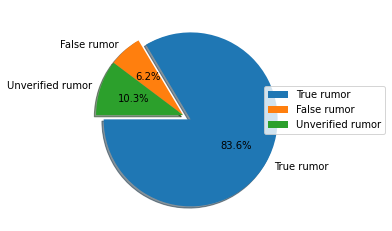

Source tweet 1: #breaking Senior IOC member Dick Pound tells @usatodaysports the Tokyo 2020 Olympic Games will be postponed amid the coronavirus pandemic: "It will come in stages. We will postpone this and begin to deal with all the ramifications of moving this, which are immense." @jaketapper
True rumor: 58.20 | False rumor: 7.18 | Unverified: 34.62 

Source tweet 2: The International Olympic Committee has announced the upcoming 2020 Tokyo Olympic Games will be postponed, via USA Today.
True rumor: 97.00 | False rumor: 0.67 | Unverified: 2.32 

Source tweet 3: I’m hearing the Olympic Committee will likely postpone the games for a year or two but not cancel. Maybe we could go back to doing winter and summer in the same year I liked that better.
True rumor: 74.02 | False rumor: 19.45 | Unverified: 6.53 

Source tweet 4: Senior figures in British sport are now “90 per cent certain” that the Olympic Games in Tokyo will be postponed.
True rumor: 68.84 | False rumor: 4.83 | Unverified: 26.3

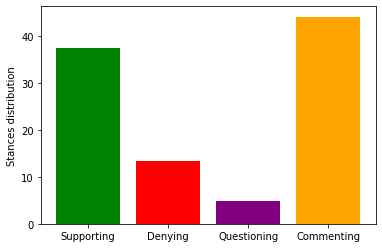

Reply 1: It’s the right thing. I feel badly but it’s not worth the risks
Supporting: 29.72 | Deny: 23.81 | Query: 14.72 | Comment: 31.74

Reply 2: Should the Tokyo Olympic be cancelled rather than postponed, no country would try to host such a huge international event with enormous risk. If the Olympic is a noble event with worldwide commitments, would not it be more constructive to discuss "how to protect the Olympics"?
Supporting: 20.39 | Deny: 7.02 | Query: 2.04 | Comment: 70.55

Reply 3: No. "Senior IOC member Dick Pound." This is not real and I will not fall for this.
Supporting: 19.62 | Deny: 38.25 | Query: 10.49 | Comment: 31.64

Reply 4: To make it happen, Japan needs to aggressively start testing, tracing, isolating and treating people as well as informing people in utmost sincere and transparent way. Otherwise, this outbreak will never end as the world is interconnected and interdependent.
Supporting: 6.84 | Deny: 13.94 | Query: 4.41 | Comment: 74.81

Reply 5: Finally!!
Suppo

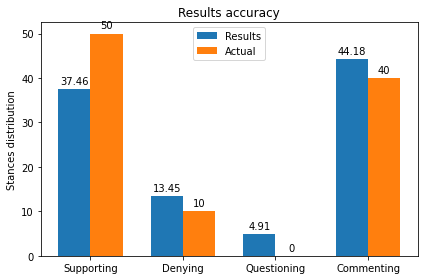

In [1]:
import fasttext
import sys
from cleantext import clean
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt

skipgram_path = os.path.join('embedding', 'model_skipgram.bin')

fasttext.FastText.eprint = print

def main():
    # load the fasttext model
    if not os.path.isfile(skipgram_path):
        print('Skipgram model not found')
        sys.exit()
    else:
        skipgram_model = fasttext.load_model(skipgram_path)
        print('------------------------------------------------------------------------------------------------------------------------------------')

    rumors = ['#breaking Senior IOC member Dick Pound tells @usatodaysports the Tokyo 2020 Olympic Games will be postponed amid the coronavirus pandemic: "It will come in stages. We will postpone this and begin to deal with all the ramifications of moving this, which are immense." @jaketapper',
              'The International Olympic Committee has announced the upcoming 2020 Tokyo Olympic Games will be postponed, via USA Today.',
              'I’m hearing the Olympic Committee will likely postpone the games for a year or two but not cancel. Maybe we could go back to doing winter and summer in the same year I liked that better.',
              'Senior figures in British sport are now “90 per cent certain” that the Olympic Games in Tokyo will be postponed.',
              'And there it is, the Olympic Games as postponed...',
              'Japanese Officials Say 2020 Olympic Games Could be Postponed.',
              'Coronavirus: Olympic Games to be postponed officially any day now as 2020 organisers face up to the inevitable.',
              'Coronavirus will postpone the Olympics, IOC says.']
    replies = ['It’s the right thing. I feel badly but it’s not worth the risks',
               'Should the Tokyo Olympic be cancelled rather than postponed, no country would try to host such a huge international event with enormous risk. If the Olympic is a noble event with worldwide commitments, would not it be more constructive to discuss "how to protect the Olympics"?',
               'No. "Senior IOC member Dick Pound." This is not real and I will not fall for this.',
               'To make it happen, Japan needs to aggressively start testing, tracing, isolating and treating people as well as informing people in utmost sincere and transparent way. Otherwise, this outbreak will never end as the world is interconnected and interdependent.',
               'Finally!!',
               'Smart move. If they did not postpone, they would have an Olympics with high school JV team swimmers and empty stands.',
               'Good decision.',
               'Ok now I know it’s serious.',
               'Good news. I watch olympics but we need to shut everything down at least until new cases drops dramatically across the globe.',
               'When reached for comment regarding the difficult of the decision, Dick Pound stated simply, “It was hard.”']

    examine_example(skipgram_model,
                    rumors,
                    replies
                    )


def examine_example(fasttext_model, rumors, replies):
    rumors_list = []
    for rumor in rumors:
        rumor = tweet_cleaner(rumor)
        rumors_list.append(rumor)

    replies_list = []
    for reply in replies:
        reply = tweet_cleaner(reply)
        replies_list.append(reply)

    rumors_list_embedded = np.zeros((len(rumors_list), input_length), dtype=np.float32)
    replies_list_embedded = np.zeros((len(replies_list), input_length), dtype=np.float32)

    for i, rumor in enumerate(rumors_list):
        rumors_list_embedded[i, :] = fasttext_model.get_sentence_vector(rumor)

    for i, reply in enumerate(replies_list):
        replies_list_embedded[i, :] = fasttext_model.get_sentence_vector(reply)

    # load our multi-task model
    # for rumors
    data_rumors = TensorDataset(torch.from_numpy(rumors_list_embedded))
    loader_rumors = DataLoader(data_rumors, shuffle=False, batch_size=int(len(rumors_list)/2))

    # for stances
    data_replies = TensorDataset(torch.from_numpy(replies_list_embedded))
    loader_replies = DataLoader(data_replies, shuffle=False, batch_size=int(len(replies_list)/2))

    # torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
    is_cuda = torch.cuda.is_available()

    # if we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
    if is_cuda:
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

    # create the model
    model_multi_task = GRUMultiTask(input_length=input_length,
                                    hidden_length_rumors=hidden_length_rumors,
                                    hidden_length_stances=hidden_length_stances,
                                    hidden_length_shared=hidden_length_shared,
                                    loss_func='BCELoss',
                                    is_dropout=False
                                    )
    model_multi_task.to(device)

    # Loading the model
    model_multi_task.load_state_dict(torch.load(os.path.join('model', 'model_state_dict.pt')))

    # Load hidden states (get initial 'h' vectors of model's GRUs)
    try:
        with open(os.path.join('model', 'h_prevs.pickle'), 'rb') as fp:
            h_training = pickle.load(fp)
            h_training = (torch.from_numpy(h_training['h_1']).to(device),
                          torch.from_numpy(h_training['h_2']).to(device),
                          torch.from_numpy(h_training['h_3']).to(device))
    except EnvironmentError:
        h_training = model_multi_task.init_hidden()
    h_prev_task_rumors_val, h_prev_task_stances_val, h_prev_shared_val = h_training

    out_r = []  # results for rumor detection task
    out_s = []  # results for stance detection task

    # run the model
    for inputs_rumors, inputs_replies in zip(loader_rumors, loader_replies):
        inputs_rumors, inputs_replies = inputs_rumors[0].to(device), inputs_replies[0].to(device)

        for i in range(1):
            # Forward pass for rumor task, to get outputs of the model
            output, h_prev_shared_val, h_prev_task_rumors_val = model_multi_task(inputs_rumors,
                                                                                h_prev_shared_val,
                                                                                task_rumors_no,
                                                                                h_prev_rumors=h_prev_task_rumors_val)
            out_r += output
            # Forward pass for stance task, to get outputs of the model
            output, h_prev_shared_val, h_prev_task_stances_val = model_multi_task(inputs_replies,
                                                                                    h_prev_shared_val,
                                                                                    task_stances_no,
                                                                                    h_prev_stances=h_prev_task_stances_val)
            out_s += output

    # print results for rumors
    print('\nPredictions for rumor detection task: ')
    true_rumors = []
    false_rumors = []
    unverified_rumors = []

    for output in out_r:
        true_rumors.append(output[0].item())
        false_rumors.append(output[1].item())
        unverified_rumors.append(output[2].item())

    avg_true_rumor = np.mean(true_rumors) * 100
    avg_false_rumor = np.mean(false_rumors) * 100
    avg_true_unverified = np.mean(unverified_rumors) * 100

    # plot the results
    slices = [avg_true_rumor, avg_false_rumor, avg_true_unverified]
    activities = ['True rumor', 'False rumor', 'Unverified rumor']
    plt.pie(slices, labels=activities, startangle=180, shadow=True, explode=(0.1, 0, 0), autopct='%1.1f%%')
    plt.legend(loc="center left", bbox_to_anchor=(0.85, 0.1, 0.5, 0.85))
    plt.show()

    for i, (tweet, output) in enumerate(zip(rumors, out_r)):
        print('Source tweet {}: {}'.format(i + 1, tweet))
        print('True rumor: {:.2f} | False rumor: {:.2f} | Unverified: {:.2f} \n'.format((output[0]*100),
                                                                                        (output[1]*100),
                                                                                        (output[2]*100)))
    # print results for stances
    print('\nPredictions for stances task: ')

    support_stances = []
    deny_stances = []
    query_stances = []
    commenting_stances = []

    for output in out_s:
        support_stances.append(output[0].item())
        deny_stances.append(output[1].item())
        query_stances.append(output[2].item())
        commenting_stances.append(output[3].item())

    avg_support_stances = np.mean(support_stances) * 100
    avg_deny_stances = np.mean(deny_stances) * 100
    avg_query_stances = np.mean(query_stances) * 100
    avg_commenting_stances = np.mean(commenting_stances) * 100

    # plot the results
    left = [1, 2, 3, 4]  # x-coordinates of left sides of bars
    height = [avg_support_stances, avg_deny_stances, avg_query_stances, avg_commenting_stances]  # heights of bars
    tick_label = ['Supporting', 'Denying', 'Questioning', 'Commenting']  # labels for bars

    # plotting a bar chart
    plt.bar(left, height, tick_label=tick_label, width=0.8, color=['green', 'red', 'purple', 'orange'])
    plt.ylabel('Stances distribution')
    plt.show()
        
    for i, (tweet, output) in enumerate(zip(replies, out_s)):
        print('Reply {}: {}'.format(i + 1, tweet))
        print('Supporting: {:.2f} | Deny: {:.2f} | Query: {:.2f} | Comment: {:.2f}\n'.format((output[0] * 100),
                                                                                             (output[1] * 100),
                                                                                             (output[2] * 100),
                                                                                             (output[3] * 100)))
    result_means = [round(avg_support_stances, 2), round(avg_deny_stances, 2),
                    round(avg_query_stances, 2), round(avg_commenting_stances, 2)]
    actual_means = [50, 10, 0, 40]

    x = np.arange(len(tick_label))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width / 2, result_means, width, label='Results')
    rects2 = ax.bar(x + width / 2, actual_means, width, label='Actual')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Stances distribution')
    ax.set_title('Results accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(tick_label)
    ax.legend()
    autolabel(rects1, ax)
    autolabel(rects2, ax)
    fig.tight_layout()
    plt.show()


def tweet_cleaner(tweet):
    # removal of Stop-words
    replace_set = stopwords.words('english')
    tweet_list = tweet.split(' ')
    no_stopwords = [word for word in tweet_list if word not in replace_set]
    no_stopwords = ' '.join(no_stopwords)

    # removal of @mention
    no_mentions = re.sub(r'@[\w_]+', '', no_stopwords)

    clean_tweet = clean(no_mentions,
                        fix_unicode=True,  # fix various unicode errors
                        to_ascii=True,  # transliterate to closest ASCII representation
                        lower=True,  # lowercase text
                        no_line_breaks=True,  # fully strip line breaks as opposed to only normalizing them
                        no_urls=True,  # replace all URLs with a special token
                        no_emails=True,  # replace all email addresses with a special token
                        no_phone_numbers=True,  # replace all phone numbers with a special token
                        no_numbers=False,  # replace all numbers with a special token
                        no_digits=False,  # replace all digits with a special token
                        no_currency_symbols=True,  # replace all currency symbols with a special token
                        no_punct=True,  # fully remove punctuation
                        replace_with_url="<URL>",
                        replace_with_email="<EMAIL>",
                        replace_with_phone_number="<PHONE>",
                        replace_with_number="<NUMBER>",
                        replace_with_digit="0",
                        replace_with_currency_symbol="<CUR>",
                        lang="en"
                        )
    return clean_tweet


def autolabel(rects, ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
                    

main()